In [1]:
import pandas as pd
import numpy as np
import h5py
import datetime
import matplotlib.pyplot as plt
from scipy import interpolate
file_name = "more3/connect_two_spectrometers.h5"
h5_file = h5py.File(file_name, "r")

In [2]:
def create_list_of_datasets_in_h5file(h5_file):
    """
    Returns a list of the paths of all datasets in an h5 file.
    Can also be used to list all datasets under a given node (e.g., f['session001']).  In this case,
    the 'session001' is not included in the output paths.
    This comes from:
    https://stackoverflow.com/questions/44883175/how-to-list-all-datasets-in-h5py-file
    :param f:
    :return:
    """
    keys = []
    h5_file.visit(lambda key: keys.append(key) if type(h5_file[key]) is h5py._hl.dataset.Dataset else None)
    return keys


def create_list_of_groups_in_node(node):
    keys = []
    node.visit(lambda key: keys.append(key) if type(node[key]) is h5py._hl.group.Group else None)
    return keys

def create_list_of_items_in_node(item_type, h5_file, node):
    keys = []
    if item_type == "group":
        my_type = h5py._hl.group.Group
    if item_type == "dataset":
        my_type = h5py._hl.dataset.Dataset
    h5_file[node].visit(lambda key: keys.append(key) if type(h5_file[node][key]) is my_type else None)
    return keys

def create_list_of_insertions_in_node(h5_file, node):
    insertions = []
    all_groups = create_list_of_items_in_node("group", h5_file, node)
    for group in all_groups:
        if group[-6:-3] == 'ins':
            insertions.append(group)
    return insertions

def create_session_insertion_dict(h5_file):
    keys = list(h5_file.keys())
    key_dict = {}
    for key in keys:
        # session_number = int(key[-3:])
        key_dict[key] = create_list_of_insertions_in_node(h5_file, key)
    print(key_dict)
    return key_dict

def create_list_of_calibrations_in_node(h5_file, node):
    calibrations = []
    all_groups = create_list_of_items_in_node("group", h5_file, node)
    for group in all_groups:
        if group[-6:-3] == 'cal':
            calibrations.append(group)
    return calibrations


def create_session_calibration_dict(h5_file):
    keys = list(h5_file.keys())
    key_dict = {}
    for key in keys:
        key_dict[key] = create_list_of_calibrations_in_node(h5_file, key)
    print(key_dict)
    return key_dict

def get_wavelengths_vector(h5_file, session, insertion, spectrometer):
    if spectrometer == "spectrometer1":
        vector_attr = "spec1_wavelengths_vector"
    elif spectrometer == "spectrometer2":
        vector_attr = "spec2_wavelengths_vector"
    else:
        print("spectrometer not specified")
        vector_attr = ""

    insertion_group = h5_file[f"{session}/{insertion}"]
    wavelengths_vector = insertion_group.parent.attrs[vector_attr][:]
    return wavelengths_vector

def get_absorbance_spectra_in_insertion(h5_file, session, insertion):
    absorbance_string = "spectrometer1/derived/absorbances"
    absorbance_spectra = h5_file[f"{session}/{insertion}/{absorbance_string}"][:]
    print(absorbance_spectra)
    return absorbance_spectra

def get_absorbance_spectra_and_depth_in_insertion(h5_file, session, insertion):
    dset_string = "derived/absorbance_depth"
    dset = h5_file[f"{session}/{insertion}/{dset_string}"]
    absorbance_spectra = dset[:, :-2]
    depths = dset[:, -1]
    forces = dset[:, -2]
    print(absorbance_spectra)
    return absorbance_spectra, depths, forces

def get_current_time():
    return np.datetime64(datetime.datetime.now()).astype(np.int64)


def timestamp_list_to_pandas_timestamps(timestamp_list):
    series = pd.Series(timestamp_list).astype('<M8[us]')
    return series

def find_zoomed_yvalues(wavelengths_vector, absorbance_spectrum):
    
    # get min_val, max_val of 1700 to 1800 nm
    mid_waves = (wavelengths_vector > 1700) & (wavelengths_vector < 1800)
    minval = absorbance_spectrum[mid_waves].min()
    maxval = absorbance_spectrum[mid_waves].max()
    ymin = minval - (minval * 0.01)
    ymax = maxval + (maxval * 0.01)
    return ymin, ymax

In [3]:
dsets = create_list_of_datasets_in_h5file(h5_file)

In [4]:
dsets

['session002/cal001/ins001/derived/absorbance_depth',
 'session002/cal001/ins001/derived/absorbance_depth_timestamps',
 'session002/cal001/ins001/derived/depth_increment_data',
 'session002/cal001/ins001/derived/force_depth',
 'session002/cal001/ins001/derived/force_depth_timestamps',
 'session002/cal001/ins001/encoder/depths',
 'session002/cal001/ins001/encoder/timestamps',
 'session002/cal001/ins001/load_cell/forces',
 'session002/cal001/ins001/load_cell/timestamps',
 'session002/cal001/ins001/spectrometer1/derived/absorbances',
 'session002/cal001/ins001/spectrometer1/spectra',
 'session002/cal001/ins001/spectrometer1/timestamps',
 'session002/cal001/ins002/derived/absorbance_depth',
 'session002/cal001/ins002/derived/absorbance_depth_timestamps',
 'session002/cal001/ins002/derived/depth_increment_data',
 'session002/cal001/ins002/derived/force_depth',
 'session002/cal001/ins002/derived/force_depth_timestamps',
 'session002/cal001/ins002/encoder/depths',
 'session002/cal001/ins002/e

In [6]:
inserts = create_list_of_insertions_in_node(h5_file, "session024")
vis_waves = h5_file['session024/cal001'].attrs['spec1_wavelengths_vector'][:]
ftir_waves = h5_file['session024/cal001'].attrs['spec2_wavelengths_vector'][:]

In [7]:
inserts

['cal001/ins001', 'cal001/ins002', 'cal001/ins003', 'cal001/ins004']

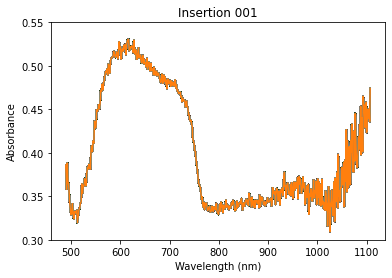

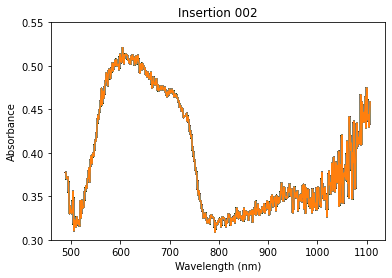

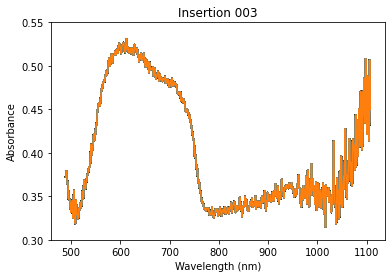

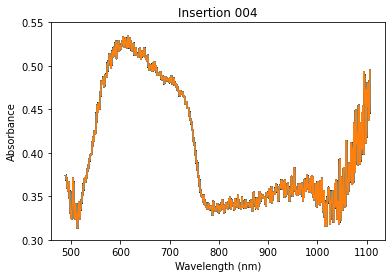

In [25]:
for i in range(len(inserts)):
    vis_spectrum = h5_file[f'session024/{inserts[i]}/spectrometer1/derived/absorbances'][:]
    ftir_spectrum = h5_file[f'session024/{inserts[i]}/spectrometer2/derived/absorbances'][:]
    fig, ax = plt.subplots()
    ax.set_ylim(0.30, 0.55)
    ax.set_ylabel("Absorbance")
    ax.set_xlabel("Wavelength (nm)")
    ax.set_title(f"Insertion {(i + 1):03d}")
    for spectrum in range(vis_spectrum[i].shape[0]):
        
        ax.plot(vis_waves, vis_spectrum[i])
    plt.show()
    

In [10]:
vis_spectrum = h5_file[f'session024/cal001/ins001/spectrometer1/derived/absorbances'][:]
vis_spectrum

array([[0.38588343, 0.35819321, 0.38833462, ..., 0.45067242, 0.4358113 ,
        0.47415927],
       [0.39097304, 0.37761983, 0.36498402, ..., 0.44463446, 0.49464627,
        0.46266679],
       [0.39329127, 0.35878732, 0.35851536, ..., 0.46704613, 0.43622521,
        0.50952836],
       [0.38948925, 0.37901902, 0.36543894, ..., 0.4661451 , 0.45440715,
        0.46219448],
       [0.39179955, 0.37360284, 0.3677207 , ..., 0.47570042, 0.46225015,
        0.51642627],
       [0.37763785, 0.36072381, 0.38119668, ..., 0.45944634, 0.47564503,
        0.48397425]])

In [19]:
vis_spectrum[0].shape

(512,)

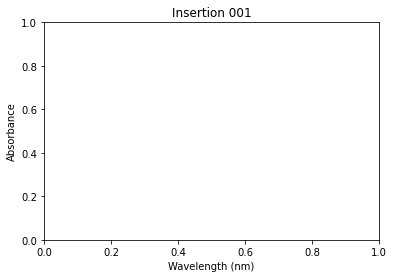

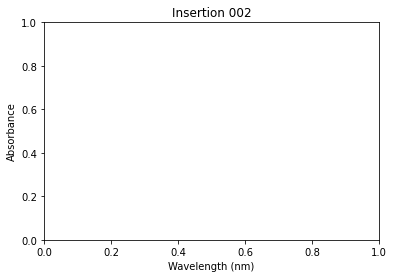

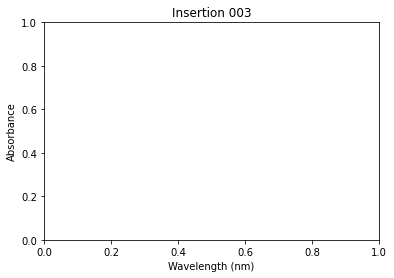

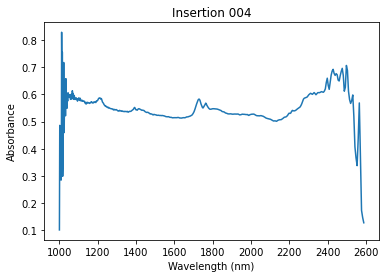

In [32]:
for i in range(len(inserts)):    
    ftir_spectrum = h5_file[f'session024/{inserts[i]}/spectrometer2/derived/absorbances'][:]
    fig, ax = plt.subplots()
    
    ax.set_ylabel("Absorbance")
    ax.set_xlabel("Wavelength (nm)")
    ax.set_title(f"Insertion {(i + 1):03d}")
for spectrum in range(ftir_spectrum[i].shape[0]):
    ax.plot(ftir_waves, ftir_spectrum[i])
    plt.show()

In [31]:
for i in range(len(inserts)):    
    ftir_spectrum = h5_file[f'session024/{inserts[i]}/spectrometer2/derived/absorbances'][:]
    print(ftir_spectrum.shape)

(8, 700)
(24, 700)
(8, 700)
(39, 700)


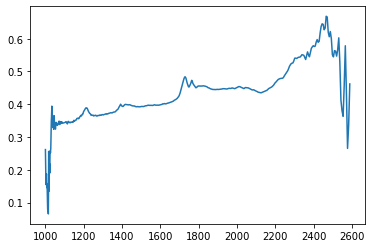

In [34]:
plt.plot(ftir_waves, ftir_spectrum[0])

In [37]:
h5_file[f'session024/cal001/ins004/derived/absorbance_depth'][:]

array([[3.83929161e-01, 3.82929497e-01, 3.57322450e-01, ...,
        1.27634312e-01, 2.05604000e+04, 1.17408524e+00],
       [3.78920967e-01, 3.70843462e-01, 3.66654383e-01, ...,
        1.95493383e-01, 2.15118000e+04, 2.80369759e+00],
       [3.91468758e-01, 3.72067690e-01, 3.62716551e-01, ...,
        4.01365842e-01, 2.14914000e+04, 4.39048729e+00],
       ...,
       [4.02350754e-01, 3.94231182e-01, 3.65438935e-01, ...,
        9.08174116e-01, 2.83370000e+04, 5.49297302e+01],
       [3.65010974e-01, 3.67797906e-01, 3.86419671e-01, ...,
        9.92362960e-01, 2.51646000e+04, 5.65393799e+01],
       [3.90973035e-01, 3.64321718e-01, 3.54946410e-01, ...,
        3.27863996e-01, 2.58200000e+04, 5.80763306e+01]])

In [38]:
abs_depth = h5_file[f'session024/cal001/ins004/derived/absorbance_depth'][:]

In [39]:
abs_depth.shape

(37, 1214)

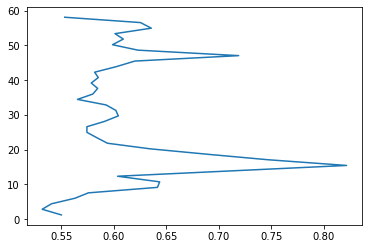

In [40]:
plt.plot(abs_depth[:, 1000], abs_depth[:, -1])

In [46]:
mean_abs = abs_depth[:, :-2].mean(axis=1)

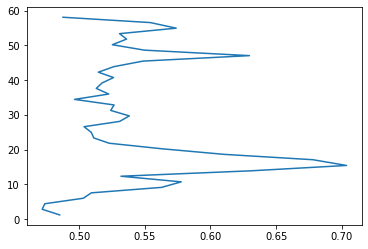

In [47]:
plt.plot(mean_abs, abs_depth[:, -1])

In [48]:
std_abs = abs_depth[:, :-2].std(axis=1)

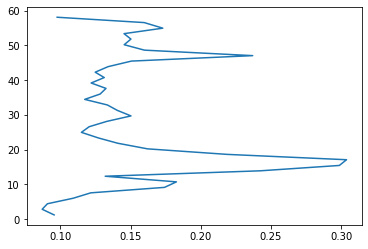

In [49]:
plt.plot(std_abs, abs_depth[:, -1])

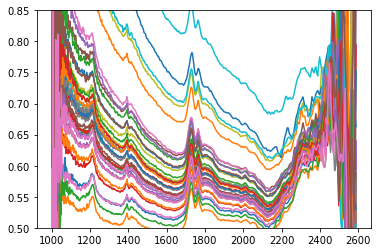

In [56]:

fig, ax = plt.subplots()
ax.set_ylim(0.5, 0.85)
for i in range(abs_depth.shape[0]):   
    ax.plot(ftir_waves, abs_depth[i, 512:-2])
plt.show()

In [51]:
vis_waves.shape

(512,)

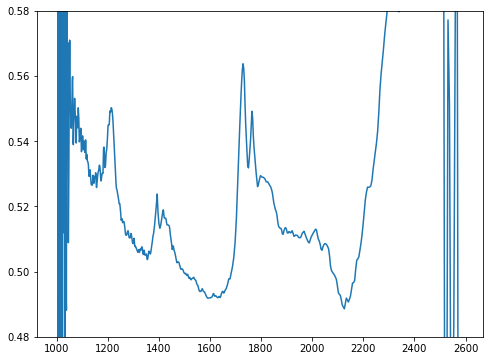

In [62]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_ylim(.48, .58)
ax.plot(ftir_waves, abs_depth[1, 512:-2])

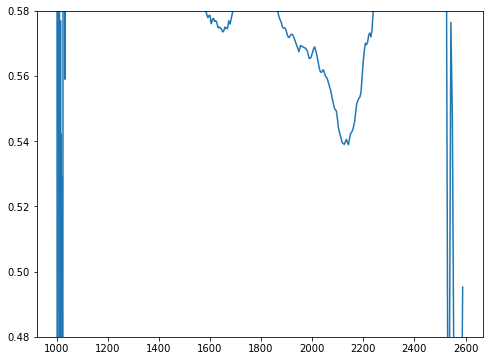

In [63]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_ylim(.48, .58)
ax.plot(ftir_waves, abs_depth[7, 512:-2])

In [64]:
ftir_ins1 = h5_file[f'session024/cal001/ins001/derived/absorbance_depth'][:]

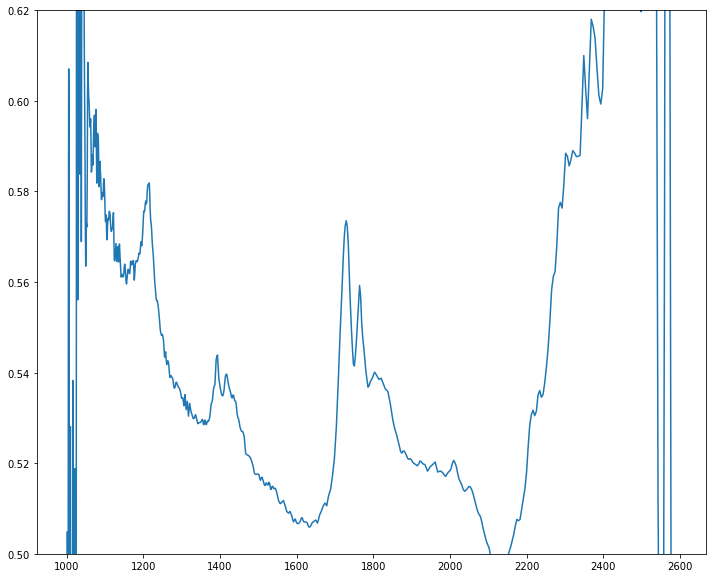

In [70]:
fig, ax = plt.subplots(figsize=(12, 10))
ax.set_ylim(.50, .62)
ax.plot(ftir_waves, ftir_ins1[0, 512:-2])

In [75]:
ftir_calib = h5_file[f'session024/cal001'].attrs['white_spectrum2'][:]

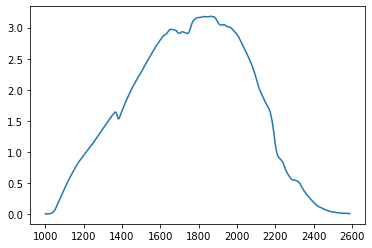

In [76]:
plt.plot(ftir_waves, ftir_calib)